In [1]:
from jqdatasdk import *
auth('13051857330','857330') #ID是申请时所填写的手机号；Password为聚宽官网登录密码，新申请用户默认为手机号后6位
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# import matplotlib
import statsmodels.api as sm 
import seaborn as sns
from cryptory import Cryptory
# for readability, reduce number of rows shown by default
pd.options.display.max_columns = 40
import tushare as ts
# import akshare as ak
#AkShare 是基于 Python 的开源金融数据接口库, 目的是实现对股票, 期货, 期权, 基金, 外汇, 债券, 指数, 
#数字货币等金融产品的基本面数据、实时和历史行情数据、衍生数据从数据采集, 数据清洗, 到数据落地的一套开源工具, 满足金融数据科学家, 
#数据科学爱好者在金融数据获取方面的需求.



auth success 


#### Extract industry information

get_industries - 获取行业列表

#### Get the industry index info

In [2]:
# Method 2: 'sw_l1'
swhy = get_industries(name='sw_l1', date='2020-01-23')
swhy = swhy.rename_axis('industrycode').reset_index()
swhy.head()

# yy stands for 医药 801150
# jt stands for 交通 801170
# xx stands for 休闲 801210
# can be adjusted 
start_date='2020-01-01'
examined_industry = swhy['industrycode'].astype(str)
today = dt.datetime.strftime(dt.datetime.today(),"%Y-%m-%d")
ystday= dt.datetime.strftime(dt.datetime.today()-dt.timedelta(days=1),"%Y-%m-%d")
# get 沪深300 
hs300 = get_price('000300.XSHG', start_date=start_date, end_date = today, frequency='daily')
hs300['change_pct']=hs300['close'].pct_change()*100
hs300.to_csv('stock_virus\\000300.csv')
hs300=hs300.reset_index()
hs300=hs300.dropna()
X1 = hs300[['change_pct']]
X1 = sm.add_constant(X1)
CAPM = pd.DataFrame()
# CAPM = pd.DataFrame(index = industry_profile.index)
for industry in examined_industry:
    # get individual industry return info
    data = finance.run_query(query(finance.SW1_DAILY_PRICE).filter(finance.SW1_DAILY_PRICE.code==industry, finance.SW1_DAILY_PRICE.date>=start_date, finance.SW1_DAILY_PRICE.date<=today))
    data = pd.DataFrame(data)
    data = data[1:]
    # regression to solve for beta
    # add .values in the end if does not need the column names
    col=data[['change_pct']].columns
    y1 = data[['change_pct']]
    model = sm.OLS(y1, X1).fit()
    name = swhy.loc[swhy['industrycode']==industry,'name'].values[0]
    industry_profile = pd.DataFrame(model.params)
    industry_profile.loc['return'] = data.iloc[-1,-1]
    # Cannot write CAPM[name]
    CAPM[[name]] = industry_profile
CAPM=CAPM.T
CAPM = CAPM.rename_axis('industry').reset_index()
CAPM = CAPM.rename(columns = {'change_pct':'beta', 'return':today[5:]+'_return'})
####
# Other indices or assets
####
# 黄金
hj = get_extras('futures_sett_price', 'AU9999.XSGE', start_date='2020-01-01', end_date=today, df=True, count=None)
hjtoday = hj.pct_change().iloc[-1,-1]*100
CAPM.loc[len(CAPM)]=['上期所黄金*',np.nan,np.nan,hjtoday]
# bitcoin
my_cryptory = Cryptory(from_date="2020-01-01")
# get prices from bitinfocharts
priceinfo=pd.DataFrame()
priceinfo=my_cryptory.extract_bitinfocharts("btc")
priceinfo=priceinfo.iloc[::-1]
btctoday = priceinfo[['btc_price']].pct_change().iloc[-1,-1]*100
CAPM.loc[len(CAPM)]=['比特币*',np.nan,np.nan,btctoday]
# 创业板指数
cyindex = get_price('399006.XSHE', start_date=start_date, end_date = today, frequency='daily')

cytoday = cyindex.pct_change().iloc[-1,1]*100
CAPM.loc[len(CAPM)]=['创业板指数*',np.nan,np.nan,cytoday]

####
# Get index
####
indices = ts.get_index()
pd.options.display.max_rows = 30
tbondtoday = indices.loc[indices['name']=='国债指数','change'].values[0]
CAPM.loc[len(CAPM)]=['国债指数*',np.nan,np.nan,tbondtoday]

CAPM.to_csv('stock_virus\\data\\'+today[5:]+'_return.csv', encoding='utf_8_sig')
# aggregated = pd.read_csv('stock_virus\\data\\aggregated_'+ystday[5:]+'_return.csv', index_col=0, encoding='utf_8_sig')
# aggregated = pd.merge(aggregated,CAPM[['industry',today[5:]+'_return']],how='inner',on='industry')
# aggregated.to_csv('stock_virus\\data\\aggregated_'+today[5:]+'_return.csv', encoding='utf_8_sig')

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [4]:
# ystday= dt.datetime.strftime(dt.datetime.today()-dt.timedelta(days=3),"%Y-%m-%d")
# ystday

'2020-02-07'

In [3]:
todayreturn = pd.read_csv('stock_virus\\data\\'+today[5:]+'_return.csv')
ystreturn = pd.read_csv('stock_virus\\data\\'+ystday[5:]+'_return.csv')
cumreturn = pd.merge(todayreturn[['industry',today[5:]+'_return']],ystreturn[['industry',ystday[5:]+'_return']],how='inner',on='industry')
cumreturn[ystday[5:]+'_return']=(((cumreturn[today[5:]+'_return']/100+1)*(cumreturn[ystday[5:]+'_return']/100+1))-1)*100
cumreturncp = cumreturn.copy()
cumreturncp[today[5:]+'_return']=cumreturncp[ystday[5:]+'_return']
cumreturncp = cumreturncp[['industry',today[5:]+'_return']]
cumreturncp.to_csv('stock_virus\\data\\'+today[5:]+'_return.csv',encoding='utf_8_sig')
cumreturn=cumreturn.rename(columns = {today[5:]+'_return':'当日回报率',ystday[5:]+'_return':'累计回报率'})
cumreturn=cumreturn.sort_values('累计回报率',ascending=False)

CAPMplot = cumreturn.melt(id_vars=['industry'], value_vars=['当日回报率','累计回报率'],var_name='day', value_name='return')


In [111]:
######
# Some alternative lines
######
# tem =CAPMplot.pivot(index='industry', columns='day', values='return')
# cumreturn=tem.sort_values('累计回报率',ascending=False)
# listOfSeries = [pd.Series(['创业板指数*', '当日回报率', 3.023854], index=CAPMplot.columns ) ,
#                 pd.Series(['创业板指数*', '累计回报率', 0.61625], index=CAPMplot.columns ) ]
# CAPMplot = CAPMplot.append(listOfSeries , ignore_index=True)
# CAPMplot = CAPMplot.sort_values(['day','return'],ascending=[False,False])
# # CAPMplot = CAPMplot.sort_values(['day'],ascending=True)
# CAPMplot[CAPMplot['day']=='累计回报率'].sort_values(['day','return'],ascending=[False,False])
# CAPMplot = pd.concat([CAPMplot[CAPMplot['day']=='当日回报率'],CAPMplot[CAPMplot['day']=='累计回报率']])
# CAPMplot.reset_index(inplace=True)

# ((cyindex[cyindex.index>='2020-01-23']['close'].pct_change()+1).cumprod()-1).values[-2]*100

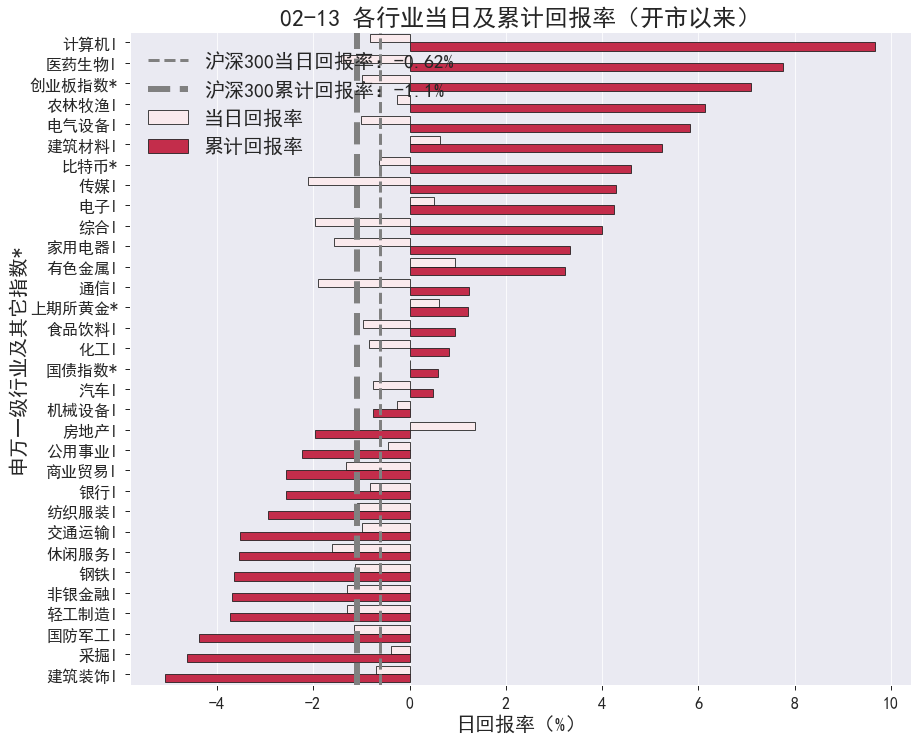

In [4]:
# https://python-graph-gallery.com/100-calling-a-color-with-seaborn/
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
sns.set_context('paper')
# CAPMplot = CAPM.sort_values(today[5:]+'_return', ascending = False)
threshold = hs300.iloc[-1,-1]
cum_threshold = ((hs300[hs300['index']>='2020-02-03']['change_pct']/100+1).cumprod()-1).values[-1]*100
# CAPMplot['below_thre'] = np.minimum(CAPMplot[today[5:]+'_return'], threshold)
# CAPMplot['above_zero'] = np.maximum(CAPMplot[today[5:]+'_return'], 0)
# CAPMplot['below_zero'] = np.minimum(CAPMplot[today[5:]+'_return'], 0)

# Plotting
f, ax = plt.subplots(figsize = (14,12))
plt.title(today[5:]+' 各行业当日及累计回报率（开市以来）', fontsize=24)
sns.set_color_codes('muted')
sns.barplot(x = 'return', y = 'industry', hue ='day', data = CAPMplot, color = 'crimson', edgecolor = 'k')
plt.axvline(x=threshold,linewidth=3, color = 'gray', linestyle='--', label='沪深300当日回报率：{}%'.format(round(threshold,2)))
plt.axvline(x=cum_threshold,linewidth=6, color = 'gray', linestyle='--', label='沪深300累计回报率：{}%'.format(round(cum_threshold,2)))
# sns.set_color_codes('muted')
# sns.barplot(x = 'above_zero', y = 'industry', data = CAPMplot, color = 'r', edgecolor = 'w')

# sns.set_color_codes('pastel')
# sns.barplot(x = 'below_thre', y = 'industry', data = CAPMplot, color = 'r', edgecolor = 'w')

# sns.set_color_codes('pastel')
# sns.barplot(x = 'below_zero', y = 'industry', data = CAPMplot, color = 'b', edgecolor = 'w' )

ax.legend(ncol = 1, loc = 'upper left',fontsize=20)
# sns.despine(left = True, bottom = True)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel("申万一级行业及其它指数*", fontsize=20)
plt.xlabel("日回报率（%）", fontsize=20)
plt.savefig('stock_virus\\'+today[5:]+' 各行业当日及累计回报率（开市以来）'+".png")

In [21]:
vdf=finance.run_query(query(finance.SW1_DAILY_VALUATION).filter(finance.SW1_DAILY_VALUATION.code=='801150', finance.SW1_DAILY_VALUATION.date>='2020-01-01').limit(20))
import pandas as pd
vdf = pd.DataFrame(vdf)
vdf

,id,date,code,name,turnover_ratio,pe,pb,average_price,money_ratio,circulating_market_cap,average_circulating_market_cap,dividend_ratio
0,1592677,2020-01-02,801150,医药生物,1.9303,36.53,3.43,22.17,7.05,3.438264e+12,1.146088e+10,0.69
1,1593393,2020-01-03,801150,医药生物,1.4994,36.45,3.43,22.19,6.51,3.426795e+12,1.142265e+10,0.69
2,1594109,2020-01-06,801150,医药生物,1.6313,36.26,3.41,22.12,6.25,3.408031e+12,1.136010e+10,0.69
3,1594825,2020-01-07,801150,医药生物,1.5086,36.84,3.46,22.50,6.16,3.462164e+12,1.154055e+10,0.68
4,1595541,2020-01-08,801150,医药生物,1.4495,36.40,3.42,22.24,5.17,3.420006e+12,1.140002e+10,0.69
5,1596257,2020-01-09,801150,医药生物,1.4238,37.29,3.51,22.84,6.85,3.512871e+12,1.170957e+10,0.67
6,1596973,2020-01-10,801150,医药生物,1.3074,37.42,3.52,22.99,6.77,3.529011e+12,1.176337e+10,0.67
7,1597689,2020-01-13,801150,医药生物,1.2691,37.67,3.54,23.21,6.43,3.557418e+12,1.185806e+10,0.66
8,1598405,2020-01-14,801150,医药生物,1.3709,37.46,3.52,23.07,6.23,3.539999e+12,1.180000e+10,0.67
9,1599121,2020-01-15,801150,医药生物,1.2481,37.60,3.54,23.22,6.50,3.547358e+12,1.182453e+10,0.67


In [6]:
factor = get_all_factors()


In [7]:
factor[factor['category']=='style']

,factor,factor_intro,category,category_intro
214,average_share_turnover_annual,年度平均月换手率,style,风险因子 - 风格因子
215,average_share_turnover_quarterly,季度平均平均月换手率,style,风险因子 - 风格因子
216,beta,BETA,style,风险因子 - 风格因子
217,book_leverage,账面杠杆,style,风险因子 - 风格因子
218,book_to_price_ratio,市净率因子,style,风险因子 - 风格因子
219,cash_earnings_to_price_ratio,现金流量市值比,style,风险因子 - 风格因子
220,cube_of_size,市值立方因子,style,风险因子 - 风格因子
221,cumulative_range,收益离差,style,风险因子 - 风格因子
222,daily_standard_deviation,日收益率标准差,style,风险因子 - 风格因子
223,debt_to_assets,资产负债率,style,风险因子 - 风格因子


In [15]:
factor_data = get_factor_values(securities=['399006.SHE'], factors=['beta','size','historical_sigma','growth','momentum'], start_date='2020-01-01', end_date='2020-02-06')

In [16]:
factor_data

{'historical_sigma':             399006.SHE
 2020-01-02         NaN
 2020-01-03         NaN
 2020-01-06         NaN
 2020-01-07         NaN
 2020-01-08         NaN
 2020-01-09         NaN
 2020-01-10         NaN
 2020-01-13         NaN
 2020-01-14         NaN
 2020-01-15         NaN
 2020-01-16         NaN
 2020-01-17         NaN
 2020-01-20         NaN
 2020-01-21         NaN
 2020-01-22         NaN
 2020-01-23         NaN
 2020-02-03         NaN
 2020-02-04         NaN
 2020-02-05         NaN
 2020-02-06         NaN, 'beta':             399006.SHE
 2020-01-02         NaN
 2020-01-03         NaN
 2020-01-06         NaN
 2020-01-07         NaN
 2020-01-08         NaN
 2020-01-09         NaN
 2020-01-10         NaN
 2020-01-13         NaN
 2020-01-14         NaN
 2020-01-15         NaN
 2020-01-16         NaN
 2020-01-17         NaN
 2020-01-20         NaN
 2020-01-21         NaN
 2020-01-22         NaN
 2020-01-23         NaN
 2020-02-03         NaN
 2020-02-04         NaN
 2020-02-05 